# Disaster Tweets NLP
The purpose of this project is to classify if tweets are disaster (1) or not a disaster(2) based on NLP. I will use BERT to classify if the tweets are disaster or not. Then I will complete hyperparameter tuning to find the best parameters. Last a quick comparison to Linear Regression to determine if the tweet is a disaster or not.

In [130]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import random
import tensorflow as tf
import keras_core as keras
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from sklearn.model_selection import cross_val_score
import re
from sklearn.model_selection import train_test_split
from transformers import BertTokenizer
from transformers import TFBertModel
from kerastuner import HyperModel
from kerastuner.tuners import RandomSearch
import kerastuner as kt
from tensorflow.keras import mixed_precision
from tensorflow.keras.layers import Input, Dropout, Dense, Layer,Flatten
from tensorflow.keras.models import Model
import optuna
from transformers import BertForSequenceClassification, Trainer, TrainingArguments
from transformers import TFBertForSequenceClassification
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score
from sklearn.feature_extraction.text import TfidfVectorizer

## Data Cleaning and EDA

In [45]:
testData = pd.read_csv('nlp-getting-started/test.csv')
trainData = pd.read_csv('nlp-getting-started/train.csv')

In [46]:
testData.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3263 entries, 0 to 3262
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        3263 non-null   int64 
 1   keyword   3237 non-null   object
 2   location  2158 non-null   object
 3   text      3263 non-null   object
dtypes: int64(1), object(3)
memory usage: 102.1+ KB


In [47]:
testData.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


In [48]:
trainData.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


In [49]:
trainData.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [50]:
#So to clean the data I am going to drop some columns
trainDataclean =trainData.drop(columns=['keyword', 'location', 'id'])
trainDataclean.head()

,text,target
0,Our Deeds are the Reason of this #earthquake M...,1
1,Forest fire near La Ronge Sask. Canada,1
2,All residents asked to 'shelter in place' are ...,1
3,"13,000 people receive #wildfires evacuation or...",1
4,Just got sent this photo from Ruby #Alaska as ...,1


In [51]:
#Further cleaning the data by removing punctuation
trainDataclean['text'] = trainDataclean['text'].str.replace(r'#\w+', '', regex=True)

In [52]:
trainDataclean['text']=trainDataclean['text'].str.replace(',', '').str.replace("'", '').str.replace('.','')


In [53]:
trainDataclean.head()

,text,target
0,Our Deeds are the Reason of this May ALLAH Fo...,1
1,Forest fire near La Ronge Sask Canada,1
2,All residents asked to shelter in place are be...,1
3,13000 people receive evacuation orders in Cal...,1
4,Just got sent this photo from Ruby as smoke f...,1


In [54]:
trainDataclean['text'] = trainDataclean['text'].str.lower()

In [55]:
trainDataclean.head()

,text,target
0,our deeds are the reason of this may allah fo...,1
1,forest fire near la ronge sask canada,1
2,all residents asked to shelter in place are be...,1
3,13000 people receive evacuation orders in cal...,1
4,just got sent this photo from ruby as smoke f...,1


In [99]:
trainDataclean

,text,target
0,our deeds are the reason of this may allah fo...,1
1,forest fire near la ronge sask canada,1
2,all residents asked to shelter in place are be...,1
3,13000 people receive evacuation orders in cal...,1
4,just got sent this photo from ruby as smoke f...,1
...,...,...
7608,two giant cranes holding a bridge collapse int...,1
7609,@aria_ahrary @thetawniest the out of control w...,1
7610,m194 [01:04 utc]?5km s of volcano hawaii,1
7611,police investigating after an e-bike collided ...,1


In [56]:
trainDataclean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    7613 non-null   object
 1   target  7613 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 119.1+ KB


In [57]:
trainDataKeyword = trainData
trainDataKeyword = trainDataKeyword['keyword'].str.replace('%20', ' ')

trainDataKeyword = trainDataKeyword.dropna()

In [58]:

keywordCount=trainDataKeyword.value_counts()
keywordCount 

keyword
fatalities             45
deluge                 42
armageddon             42
sinking                41
damage                 41
                       ..
forest fire            19
epicentre              12
threat                 11
inundation             10
radiation emergency     9
Name: count, Length: 221, dtype: int64

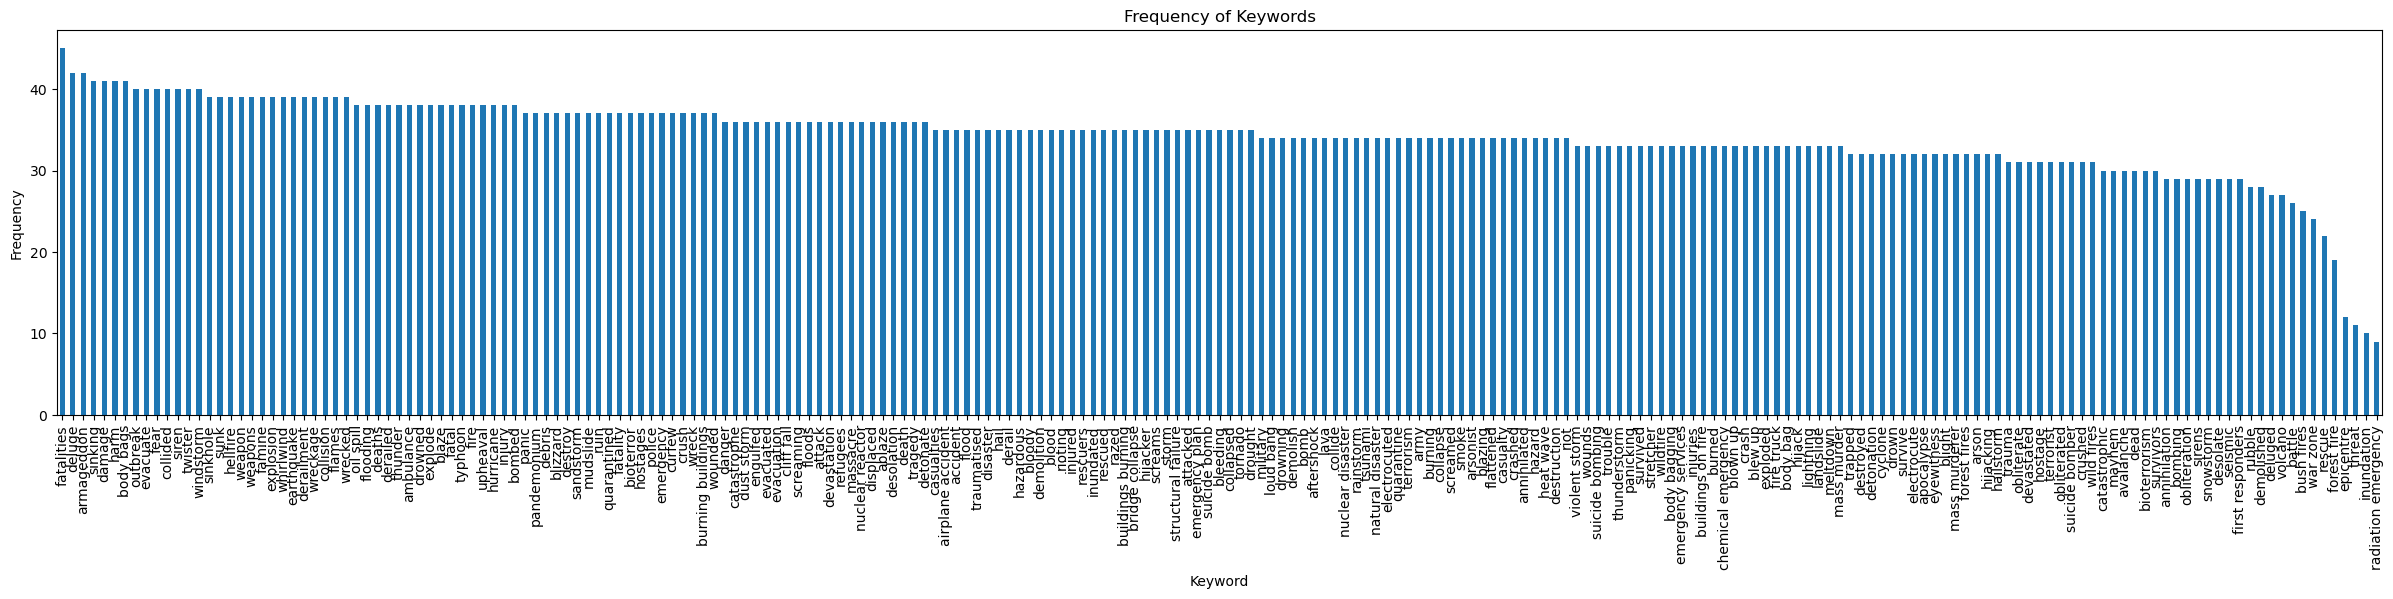

In [59]:
plt.figure(figsize=(30,5))
keywordCount.plot(kind='bar')
plt.title('Frequency of Keywords')
plt.xlabel('Keyword')
plt.ylabel('Frequency')
plt.show()

At most a keyword is represented under 50 times - which is fatalities. Further, not all testing and training data has a keyword

For that reason I believe it is ok to train solely on the text

In [60]:
counts = trainDataclean['target'].value_counts()
counts

target
0    4342
1    3271
Name: count, dtype: int64

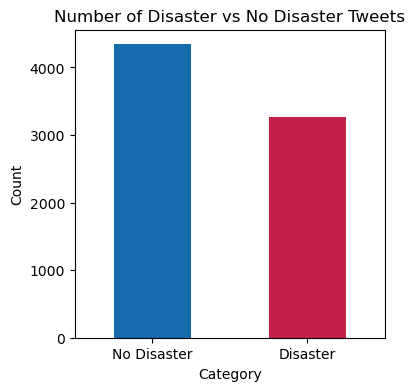

In [61]:
plt.figure(figsize=(4,4))
counts.plot(kind='bar', color=['#166bac','#c32148'])
plt.title('Number of Disaster vs No Disaster Tweets')
plt.xlabel('Category')
plt.ylabel('Count')
plt.xticks(ticks=[0, 1], labels=['No Disaster', 'Disaster'], rotation=0)
plt.show()

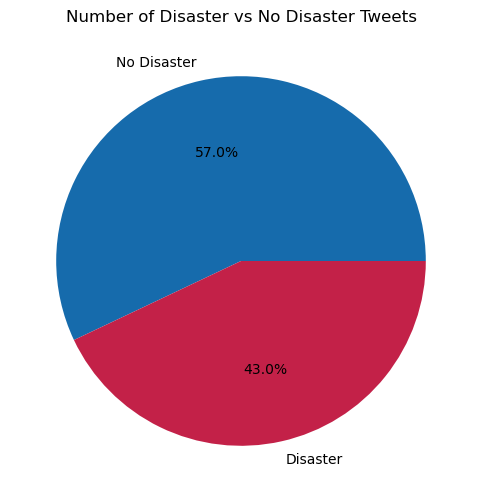

In [62]:
plt.figure(figsize=(8, 6))
counts.plot(kind='pie', labels=['No Disaster', 'Disaster'], autopct='%1.1f%%', colors=['#166bac','#c32148'])
plt.title('Number of Disaster vs No Disaster Tweets')
plt.ylabel('')
plt.show()

Slightly more no disaster tweets, now going to compare word clouds of each

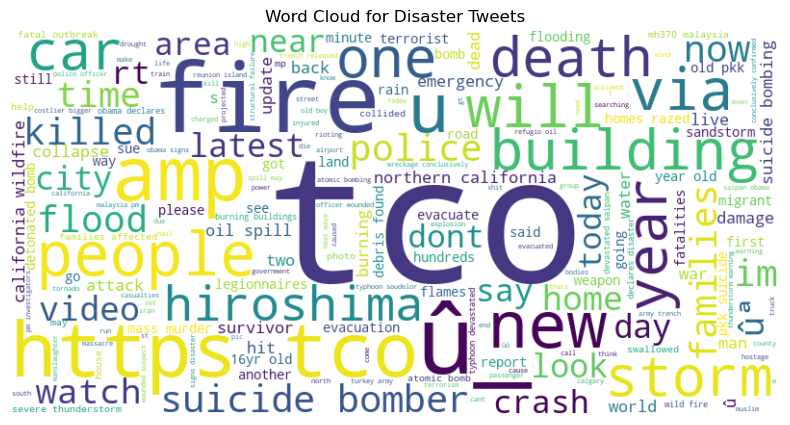

In [63]:
#word cloud for disaster tweets
disaster_tweets = trainDataclean[trainDataclean['target'] == 1]['text']
text = ' '.join(disaster_tweets)

wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud for Disaster Tweets')
plt.show()

In [64]:
#I want to remove https so lets go ahead and do some more cleaning
def remove_urls(text):
    url_pattern = re.compile(r'https?://\S+|www\.\S+')
    return url_pattern.sub(r'', text)

trainDataclean['text'] = trainDataclean['text'].apply(remove_urls)

trainDataclean['text'] = trainDataclean['text'].str.replace('û', '', regex=False)

trainDataclean['text'] = trainDataclean['text'].str.replace('amp', '', regex=False)

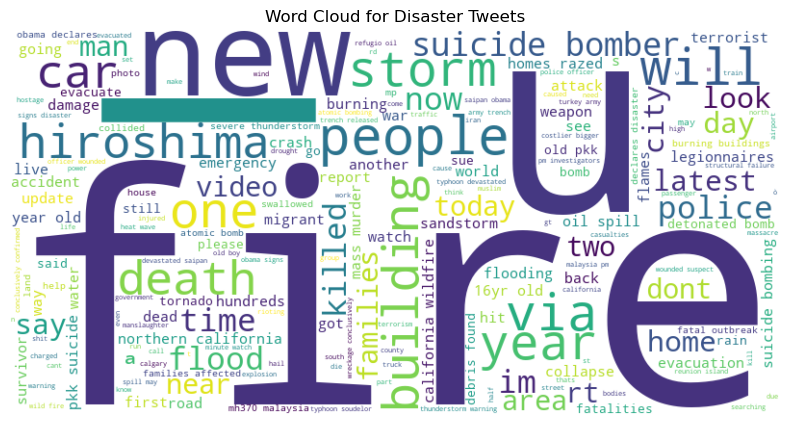

In [65]:
#word cloud for disaster tweets
disaster_tweets = trainDataclean[trainDataclean['target'] == 1]['text']
text = ' '.join(disaster_tweets)

wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud for Disaster Tweets')
plt.show()

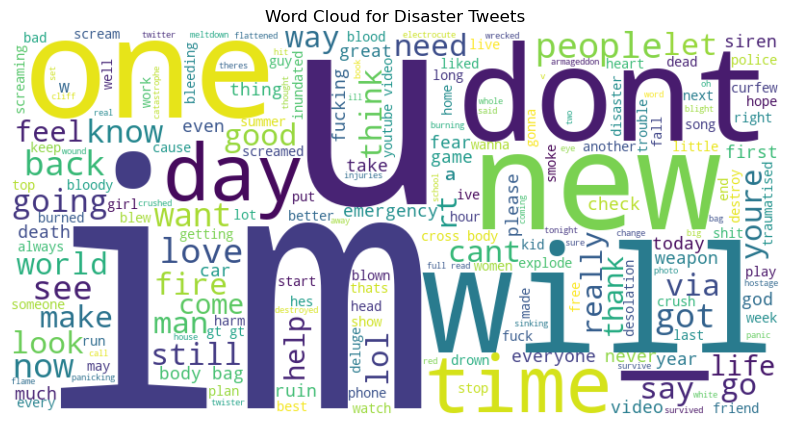

In [66]:
#word cloud for not disaster tweets
notdisaster_tweets = trainDataclean[trainDataclean['target'] == 0]['text']
nottext = ' '.join(notdisaster_tweets)

wordcloudnot = WordCloud(width=800, height=400, background_color='white').generate(nottext)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloudnot, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud for Disaster Tweets')
plt.show()

So I see differences in the words so hopefully model will work as well

In [67]:
#Split data into training and validation
X = trainDataclean['text']
y = trainDataclean['target']

Xtrain, Xval, ytrain, yval = train_test_split(X,y,test_size=0.2, random_state=42)

In [68]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
def tokenize(text, tokenizer, maxLength = 50):
    return tokenizer(
        text.tolist(),
        max_length=maxLength,
        truncation=True,
        padding=True,
        add_special_tokens=True,
        return_tensors='tf')

In [69]:
enXtrain = tokenize(Xtrain, tokenizer)
enXval = tokenize(Xval, tokenizer)

## First Model
using BERT because it is bidirectional, has good performance, and my implementation is overall lightweight so it will run on my MacBook Air.

In [71]:
bertOutput = BertLayer()([input_ids, attention_mask])
pooledOutput = Flatten()(bertOutput)
#pooledOutput = bertOutput[1]
dropout = tf.keras.layers.Dropout(0.3)(pooledOutput)
output = tf.keras.layers.Dense(1,activation='sigmoid')(dropout)

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.bias']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

In [72]:
firstModel = tf.keras.Model(inputs=[input_ids, attention_mask], outputs=output)
firstModel.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=2e-5), loss='binary_crossentropy', metrics=['accuracy'])


In [73]:
history = firstModel.fit(
    [enXtrain['input_ids'], enXtrain['attention_mask']],
    ytrain,
    validation_data=([enXval['input_ids'], enXval['attention_mask']], yval),
    epochs=3,
    batch_size=16
)

Epoch 1/3
381/381 ━━━━━━━━━━━━━━━━━━━━ 324s 844ms/step - accuracy: 0.4828 - loss: 0.7506 - val_accuracy: 0.5529 - val_loss: 0.6893
Epoch 2/3
381/381 ━━━━━━━━━━━━━━━━━━━━ 327s 859ms/step - accuracy: 0.5070 - loss: 0.7328 - val_accuracy: 0.5785 - val_loss: 0.6738
Epoch 3/3
381/381 ━━━━━━━━━━━━━━━━━━━━ 379s 851ms/step - accuracy: 0.5409 - loss: 0.7124 - val_accuracy: 0.6067 - val_loss: 0.6628


In [74]:
ypredVal = (firstModel.predict([enXval['input_ids'], enXval['attention_mask']]) > 0.5).astype("int32")

48/48 ━━━━━━━━━━━━━━━━━━━━ 66s 1s/step


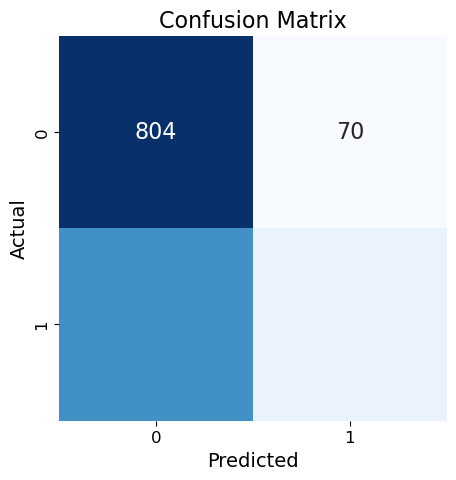

array([[804,  70],
       [529, 120]])

In [75]:
cm = confusion_matrix(yval, ypredVal)
plt.figure(figsize=(5,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, annot_kws={"size": 16})
plt.xlabel('Predicted', fontsize=14)
plt.ylabel('Actual', fontsize=14)
plt.title('Confusion Matrix', fontsize=16)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

cm

In [76]:
#Actual values below confusion matrix for some reason it wouldn't render

In [77]:
testData
testDataclean =testData.drop(columns=['keyword', 'location'])
testDataclean

,id,text
0,0,Just happened a terrible car crash
1,2,"Heard about #earthquake is different cities, s..."
2,3,"there is a forest fire at spot pond, geese are..."
3,9,Apocalypse lighting. #Spokane #wildfires
4,11,Typhoon Soudelor kills 28 in China and Taiwan
...,...,...
3258,10861,EARTHQUAKE SAFETY LOS ANGELES ÛÒ SAFETY FASTE...
3259,10865,Storm in RI worse than last hurricane. My city...
3260,10868,Green Line derailment in Chicago http://t.co/U...
3261,10874,MEG issues Hazardous Weather Outlook (HWO) htt...


In [78]:
testDataclean['text']=testDataclean['text'].str.replace(',', '').str.replace("'", '').str.replace('.','')
testDataclean['text'] = testDataclean['text'].str.replace(r'#\w+', '', regex=True)
testDataclean['text'] = testDataclean['text'].apply(remove_urls)

testDataclean['text'] = testDataclean['text'].str.replace('û', '', regex=False)
testDataclean['text'] = testDataclean['text'].str.replace('ÛÒ', '', regex=False)
testDataclean['text'] = testDataclean['text'].str.replace('amp', '', regex=False)

In [79]:
testDataclean

,id,text
0,0,Just happened a terrible car crash
1,2,Heard about is different cities stay safe eve...
2,3,there is a forest fire at spot pond geese are ...
3,9,Apocalypse lighting
4,11,Typhoon Soudelor kills 28 in China and Taiwan
...,...,...
3258,10861,EARTHQUAKE SAFETY LOS ANGELES  SAFETY FASTENE...
3259,10865,Storm in RI worse than last hurricane My city&...
3260,10868,Green Line derailment in Chicago
3261,10874,MEG issues Hazardous Weather Outlook (HWO)


In [80]:
testEn = tokenize(testDataclean['text'], tokenizer)

In [81]:
testEnPred1 = (firstModel.predict([testEn['input_ids'], testEn['attention_mask']]) > 0.5).astype("int32")


102/102 ━━━━━━━━━━━━━━━━━━━━ 165s 2s/step


In [82]:
firstresults = pd.DataFrame({
    'id': testDataclean['id'],
    'target': testEnPred1.flatten()
})

In [46]:
# add to csv
#firstresults.to_csv('output1.csv', index=False)

#### Result for the first model
![Result](firstmodel.png)

when I first ran the model it did really well, then my computer crashed and I had to re-run it and that is when it did terribly

## Second Model

### Hyperparameter Tuning
Tuning the hyperparameters to find best parameters for BERT model

In [83]:
def build_model(hp):
    input_ids = Input(shape=(50,), dtype=tf.int32, name='input_ids')
    attention_mask = Input(shape=(50,), dtype=tf.int32, name='attention_mask')

    bert_output = BertLayer()([input_ids, attention_mask])

    flattened_output = Flatten()(bert_output)

    dropout_rate = hp.Float('dropout_rate', min_value=0.1, max_value=0.5, step=0.1)
    dropout = Dropout(dropout_rate)(flattened_output)

    dense_units = hp.Int('dense_units', min_value=32, max_value=256, step=32)
    output = Dense(dense_units, activation='relu')(dropout)

    output = Dense(1, activation='sigmoid')(output)

    model = Model(inputs=[input_ids, attention_mask], outputs=output)

    model.compile(optimizer=tf.keras.optimizers.Adam(hp.Choice('learning_rate', [1e-5, 3e-5, 5e-5])),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])

    return model

In [87]:
tuner = kt.RandomSearch(build_model,
                     objective='val_accuracy',
                     executions_per_trial=1,
                     directory='tuning',
                     project_name='bert_hyperparameter_tuning',
                     max_trials=5 )

Reloading Tuner from tuning/bert_hyperparameter_tuning/tuner0.json


In [88]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)

In [89]:
tuner.search([enXtrain['input_ids'], enXtrain['attention_mask']],ytrain,
             validation_split=0.2,
             callbacks=[early_stopping],
             batch_size=32)

Trial 24 Complete [00h 03m 38s]
val_accuracy: 0.6223316788673401

Best val_accuracy So Far: 0.7405582666397095
Total elapsed time: 06h 32m 32s


In [90]:
bestHPs=tuner.get_best_hyperparameters(num_trials=1)[0]
finalBertModel = tuner.hypermodel.build(bestHPs)

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.bias']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

In [91]:
history = finalBertModel.fit(
    [enXtrain['input_ids'], enXtrain['attention_mask']],
    ytrain,
    validation_data=([enXval['input_ids'], enXval['attention_mask']], yval),
    epochs=3,
    batch_size=16
)

Epoch 1/3
381/381 ━━━━━━━━━━━━━━━━━━━━ 284s 738ms/step - accuracy: 0.6470 - loss: 0.6415 - val_accuracy: 0.7183 - val_loss: 0.5802
Epoch 2/3
381/381 ━━━━━━━━━━━━━━━━━━━━ 305s 800ms/step - accuracy: 0.6933 - loss: 0.5889 - val_accuracy: 0.7301 - val_loss: 0.5645
Epoch 3/3
381/381 ━━━━━━━━━━━━━━━━━━━━ 308s 810ms/step - accuracy: 0.7141 - loss: 0.5742 - val_accuracy: 0.7511 - val_loss: 0.5452


In [92]:
ypredVal2 = (finalBertModel.predict([enXval['input_ids'], enXval['attention_mask']]) > 0.5).astype("int32")


48/48 ━━━━━━━━━━━━━━━━━━━━ 60s 1s/step


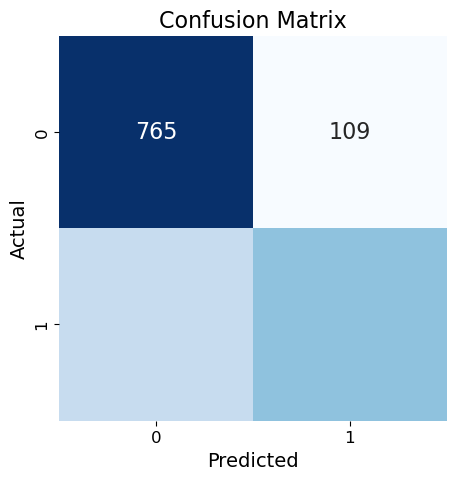

array([[765, 109],
       [270, 379]])

In [96]:
cm2 = confusion_matrix(yval, ypredVal2)
plt.figure(figsize=(5,5))
sns.heatmap(cm2, annot=True, fmt='d', cmap='Blues', cbar=False, annot_kws={"size": 16})
plt.xlabel('Predicted', fontsize=14)
plt.ylabel('Actual', fontsize=14)
plt.title('Confusion Matrix', fontsize=16)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

cm2

In [94]:
testEnPredBertFinal = (finalBertModel.predict([testEn['input_ids'], testEn['attention_mask']]) > 0.5).astype("int32")


102/102 ━━━━━━━━━━━━━━━━━━━━ 120s 1s/step


In [97]:
finalresults = pd.DataFrame({
    'id': testDataclean['id'],
    'target': testEnPredBertFinal.flatten()
})

In [98]:
# add to csv
#finalresults.to_csv('output2.csv', index=False)

### Did one last model to see if removing @ would make a difference

In [101]:
def remove_text_after_at(text):
    parts = text.split()
    filtered_parts = [part for part in parts if '@' not in part]
    return ' '.join(filtered_parts)

trainDatacleanFinal = trainDataclean
trainDatacleanFinal['text'] = trainDataclean['text'].apply(remove_text_after_at)

In [102]:
trainDatacleanFinal

,text,target
0,our deeds are the reason of this may allah for...,1
1,forest fire near la ronge sask canada,1
2,all residents asked to shelter in place are be...,1
3,13000 people receive evacuation orders in cali...,1
4,just got sent this photo from ruby as smoke fr...,1
...,...,...
7608,two giant cranes holding a bridge collapse int...,1
7609,the out of control wild fires in california ev...,1
7610,m194 [01:04 utc]?5km s of volcano hawaii,1
7611,police investigating after an e-bike collided ...,1


In [107]:
trainDatacleanFinal['text']=trainDatacleanFinal['text'].str.replace('?', '')
trainDatacleanFinal['text']=trainDatacleanFinal['text'].str.replace('&', '')

In [108]:
testDatacleanFinal = testDataclean
testDatacleanFinal['text'] = testDataclean['text'].apply(remove_text_after_at)

In [110]:
testDatacleanFinal['text'] = testDatacleanFinal['text'].str.lower()
testDatacleanFinal['text']=testDatacleanFinal['text'].str.replace('?', '')
testDatacleanFinal['text']=testDatacleanFinal['text'].str.replace('&', '')

In [111]:
testDatacleanFinal

,id,text
0,0,just happened a terrible car crash
1,2,heard about is different cities stay safe ever...
2,3,there is a forest fire at spot pond geese are ...
3,9,apocalypse lighting
4,11,typhoon soudelor kills 28 in china and taiwan
...,...,...
3258,10861,earthquake safety los angeles  safety fastene...
3259,10865,storm in ri worse than last hurricane my city;...
3260,10868,green line derailment in chicago
3261,10874,meg issues hazardous weather outlook (hwo)


In [113]:
Xf = trainDatacleanFinal['text']
yf = trainDatacleanFinal['target']

Xtrainf, Xvalf, ytrainf, yvalf = train_test_split(Xf,yf,test_size=0.2, random_state=42)

In [114]:
enXtrainf = tokenize(Xtrainf, tokenizer)
enXvalf = tokenize(Xvalf, tokenizer)

In [118]:
tuner2 = kt.RandomSearch(build_model,
                     objective='val_accuracy',
                     executions_per_trial=1,
                     directory='tuning2',
                     project_name='bert_hyperparameter_tuning2',
                     max_trials=5 )
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)

tuner2.search([enXtrainf['input_ids'], enXtrainf['attention_mask']],ytrainf,
             validation_split=0.2,
             callbacks=[early_stopping],
             batch_size=32)

Trial 5 Complete [00h 03m 33s]
val_accuracy: 0.628078818321228

Best val_accuracy So Far: 0.6576354503631592
Total elapsed time: 00h 17m 08s


In [119]:
bestHPsf=tuner2.get_best_hyperparameters(num_trials=1)[0]
finalBertModelf = tuner2.hypermodel.build(bestHPsf)

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.bias']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

In [121]:
history = finalBertModelf.fit(
    [enXtrainf['input_ids'], enXtrainf['attention_mask']],
    ytrain,
    validation_data=([enXvalf['input_ids'], enXvalf['attention_mask']], yvalf),
    epochs=3,
    batch_size=16
)

ypredVal3 = (finalBertModelf.predict([enXval['input_ids'], enXval['attention_mask']]) > 0.5).astype("int32")


Epoch 1/3
381/381 ━━━━━━━━━━━━━━━━━━━━ 268s 696ms/step - accuracy: 0.6062 - loss: 0.6612 - val_accuracy: 0.7104 - val_loss: 0.5924
Epoch 2/3
381/381 ━━━━━━━━━━━━━━━━━━━━ 272s 715ms/step - accuracy: 0.6794 - loss: 0.6045 - val_accuracy: 0.7209 - val_loss: 0.5714
Epoch 3/3
381/381 ━━━━━━━━━━━━━━━━━━━━ 285s 747ms/step - accuracy: 0.6885 - loss: 0.5992 - val_accuracy: 0.7295 - val_loss: 0.5585
48/48 ━━━━━━━━━━━━━━━━━━━━ 55s 1s/step


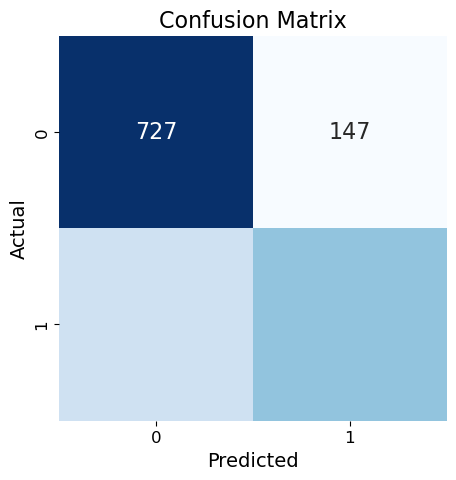

array([[727, 147],
       [267, 382]])

In [122]:
cm3 = confusion_matrix(yvalf, ypredVal3)
plt.figure(figsize=(5,5))
sns.heatmap(cm3, annot=True, fmt='d', cmap='Blues', cbar=False, annot_kws={"size": 16})
plt.xlabel('Predicted', fontsize=14)
plt.ylabel('Actual', fontsize=14)
plt.title('Confusion Matrix', fontsize=16)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

cm3

No difference

In [123]:
testEnf = tokenize(testDatacleanFinal['text'], tokenizer)

In [124]:
testEnPredBertFinalf = (finalBertModelf.predict([testEnf['input_ids'], testEnf['attention_mask']]) > 0.5).astype("int32")


102/102 ━━━━━━━━━━━━━━━━━━━━ 132s 1s/step


In [135]:
lastresults = pd.DataFrame({
    'id': testDatacleanFinal['id'],
    'target': testEnPredBertFinalf.flatten()
})

In [136]:
# add to csv
lastresults.to_csv('output3.csv', index=False)

finally a comparison to logistic regression, doesn't perform that badly but not as good as NLP

In [133]:
vectorizer = TfidfVectorizer(max_features=5000, tokenizer=lambda x: x.split())

XtrainfLog = vectorizer.fit_transform(Xtrainf)
XvalfLog= vectorizer.fit_transform(Xvalf)
#, ytrainf, yvalf


modelLogistic = LogisticRegression()
modelLogistic.fit(XtrainfLog, ytrainf)
ypredLogistic = modelLogistic.predict(XvalfLog)

print(f"Accuracy: {accuracy_score(yvalf, ypredLogistic)}")
#print(classification_report(y_test, y_pred))

Accuracy: 0.5456336178594878


/opt/anaconda3/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
